In [ ]:
!pip install mtcnn

In [ ]:
%tensorflow_version 1.x

import mtcnn
print(mtcnn.__version__)

0.1.0


In [ ]:
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


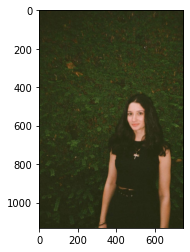

In [67]:
from matplotlib import pyplot
from google.colab import drive
drive.mount('/content/drive')
#img_path = "l5_face_rec/detection/druzhko.jpg"
img_path ="/content/drive/My Drive/Colab/face/face1/1.jpg"
img = pyplot.imread(img_path)
pyplot.imshow(img)
pyplot.show()

In [68]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6981828109833700086
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14210670766613236391
physical_device_desc: "device: XLA_CPU device"
]


In [69]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)

In [70]:
x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height

In [71]:
face = img[y1:y2, x1:x2]

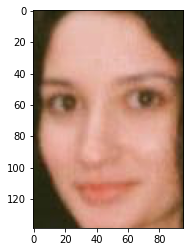

In [72]:
from PIL import Image
import numpy as np

image = Image.fromarray(face)
face_array = np.asarray(image)
pyplot.imshow(face_array)
pyplot.show()

In [73]:
def extract_face(filename, required_size=(224, 224), resize=False):
    """Функция возвращает массив-лицо и преобразует его к заданному размеру,
    если resize == True
    
    Параметры:
    filename -- строка - путь к файлу с исходным изображением
    required_size -- кортеж из двух целых чисел - размер финального изображения
    resize -- boolean, который определяет, нужно ли менять размер изображения
    
    Возвращает np.ndarray, в котором записано обрезанное изображение с найденным
    на первоначальной картинке лицом
    """
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    """Выводит изображение на экран"""
    if isinstance(img, str):
        img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

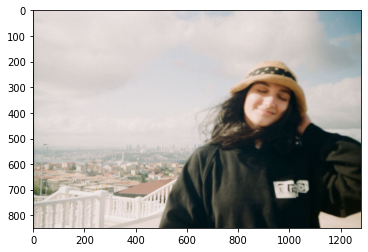

In [74]:
print_image("/content/drive/My Drive/Colab/face/face1/2.jpg")

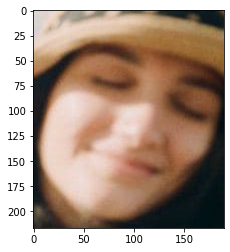

In [75]:
print_image(extract_face("/content/drive/My Drive/Colab/face/face1/2.jpg"))

In [76]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [77]:
from keras.models import model_from_json
model.load_weights('/content/drive/My Drive/Colab/face/vgg_face_weights.h5')

In [78]:
# наш выходной слой с необходимым количеством нейронов в нем
final_layer = Dense(2, activation='softmax')(model.layers[-2].output)

from keras.models import Model
model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

In [79]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_40_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 114, 114, 64)      0  

In [84]:
from os import listdir
from os.path import join
dir1 = "/content/drive/My Drive/Colab/face/face1"
dir2 = "/content/drive/My Drive/Colab/face/face2"

files1 = listdir(dir1)
files2 = listdir(dir2)

In [87]:
images1 = [extract_face(join(dir1, i), resize=True)
           for i in files1]

In [88]:
images2 = [extract_face(join(dir2, i), resize=True)
           for i in files2]

In [101]:
 X_train = images1[:-2] + images2[:-2]
y_train = [[1, 0]] * len(images1[:-2]) + [[0, 1]] * len(images2[:-2])

X_test = images1[-5:]  + images2[-5:]
y_test = [[1, 0], [1, 0], [0, 1], [0, 1]]

In [102]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [103]:
train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

In [104]:
%%time
model.fit_generator(train, epochs=100, verbose=2)

Epoch 1/100
 - 15s - loss: 0.3834 - accuracy: 0.9259
Epoch 2/100
 - 15s - loss: 0.3572 - accuracy: 0.9630
Epoch 3/100
 - 15s - loss: 0.3483 - accuracy: 1.0000
Epoch 4/100
 - 15s - loss: 0.3696 - accuracy: 0.9259
Epoch 5/100
 - 15s - loss: 0.3521 - accuracy: 1.0000
Epoch 6/100
 - 15s - loss: 0.3299 - accuracy: 1.0000
Epoch 7/100
 - 15s - loss: 0.3171 - accuracy: 0.9630
Epoch 8/100
 - 15s - loss: 0.3530 - accuracy: 0.9630
Epoch 9/100
 - 15s - loss: 0.3449 - accuracy: 1.0000
Epoch 10/100
 - 15s - loss: 0.3449 - accuracy: 0.9630
Epoch 11/100
 - 15s - loss: 0.3488 - accuracy: 0.9630
Epoch 12/100
 - 15s - loss: 0.3421 - accuracy: 0.9630
Epoch 13/100
 - 15s - loss: 0.3395 - accuracy: 0.9259
Epoch 14/100
 - 15s - loss: 0.3207 - accuracy: 0.9259
Epoch 15/100
 - 15s - loss: 0.3242 - accuracy: 0.9259
Epoch 16/100
 - 15s - loss: 0.3472 - accuracy: 0.9259
Epoch 17/100
 - 15s - loss: 0.3360 - accuracy: 0.9630
Epoch 18/100
 - 15s - loss: 0.3353 - accuracy: 0.9259
Epoch 19/100
 - 15s - loss: 0.3182 - 

In [106]:
model.save_weights("/content/drive/My Drive/Colab/face/l5_face_rec_model_weights.h5")

In [107]:
model.load_weights("/content/drive/My Drive/Colab/face/l5_face_rec_model_weights.h5")

array([[[141, 112,  94],
        [141, 114,  95],
        [142, 115,  96],
        ...,
        [ 52,  50,  53],
        [ 55,  53,  56],
        [ 70,  68,  71]],

       [[141, 114,  95],
        [140, 114,  94],
        [139, 113,  94],
        ...,
        [ 51,  49,  52],
        [ 52,  50,  53],
        [ 53,  51,  54]],

       [[141, 115,  96],
        [137, 112,  92],
        [132, 107,  87],
        ...,
        [ 54,  52,  55],
        [ 58,  56,  59],
        [ 49,  47,  50]],

       ...,

       [[ 48,  43,  47],
        [ 47,  42,  46],
        [ 49,  44,  48],
        ...,
        [ 60,  56,  57],
        [ 67,  63,  64],
        [ 66,  62,  63]],

       [[ 45,  40,  44],
        [ 46,  41,  45],
        [ 49,  43,  47],
        ...,
        [ 60,  56,  57],
        [ 66,  62,  63],
        [ 66,  62,  63]],

       [[ 47,  42,  46],
        [ 46,  41,  45],
        [ 48,  42,  46],
        ...,
        [ 59,  55,  56],
        [ 65,  61,  62],
        [ 65,  61,  62]]

In [108]:
model.predict(np.asarray(X_test))

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

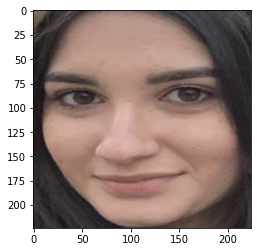

In [109]:
pyplot.imshow(Image.fromarray(X_test[0]))
pyplot.show()

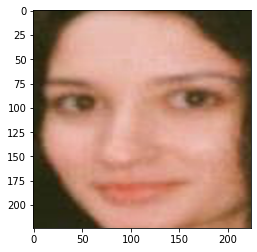

In [110]:
pyplot.imshow(Image.fromarray(X_test[1]))
pyplot.show()

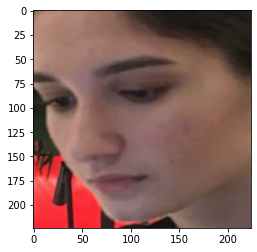

In [111]:
pyplot.imshow(Image.fromarray(X_test[2]))
pyplot.show()

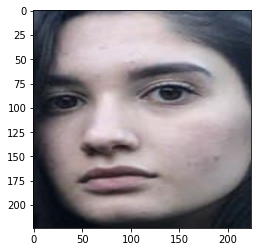

In [112]:
pyplot.imshow(Image.fromarray(X_test[3]))
pyplot.show()

In [130]:
pyplot.imshow(Image.fromarray(X_test[9]))
pyplot.show()

AttributeError: ignored

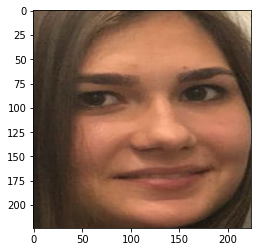

In [119]:
pyplot.imshow(Image.fromarray(X_test[]))
pyplot.show()

In [129]:
model.predict(np.asarray(X_test
                        ))

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

0


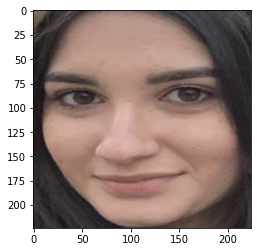

1


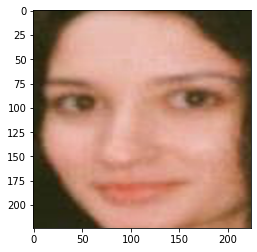

2


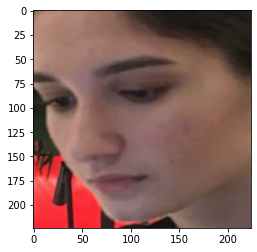

3


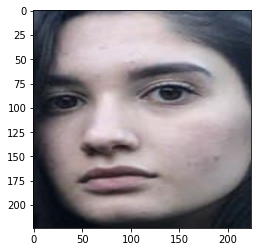

4


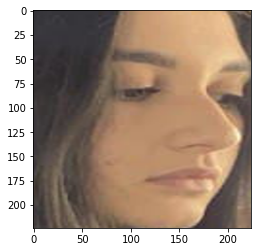

5


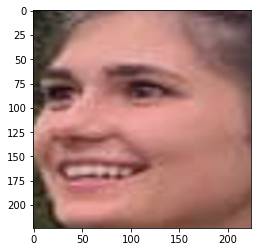

6


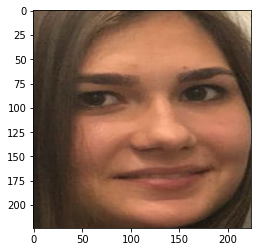

7


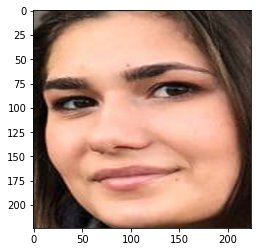

8


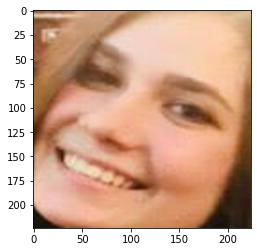

9


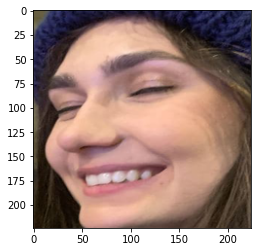

In [136]:
for i in range(10):
  pyplot.imshow(Image.fromarray(X_test[i]))
  print(i)
  pyplot.show()